<a href="https://colab.research.google.com/github/sanglee/BDS_WS/blob/main/lecture03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Biomedical Data Science Winter School

@author: Sangkyun Lee  (sangkyun@korea.ac.kr)

___ML III: Random Forest & Logistic Regression___

---

In [ ]:
# A utility function to plot decision boundaries in 2D

from matplotlib.colors import ListedColormap


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    c=[cmap(idx)]*sum(y == cl),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

    # highlight test samples
    if test_idx:
        # plot all samples
        if not versiontuple(np.__version__) >= versiontuple('1.9.0'):
            X_test, y_test = X[list(test_idx), :], y[list(test_idx)]
            warnings.warn('Please update to NumPy 1.9.0 or newer')
        else:
            X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    alpha=1.0,
                    edgecolor='black',
                    linewidths=1,
                    marker='o',
                    s=55, label='test set')

---
### Loading the IRIS data

In [ ]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
        'machine-learning-databases/iris/iris.data', names= ['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width', 'Label'])

In [ ]:
df.head()

,Sepal Length,Sepal Width,Petal Length,Petal Width,Label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [ ]:
# Prepare data matrix and labels

import numpy as np
from sklearn.preprocessing import LabelEncoder

X = df.iloc[:, [2, 3]].values
y = df.iloc[:, 4].values
enc_y = LabelEncoder()
enc_y.fit(y)
y = enc_y.transform(y)
feature_names = df.columns.values[[2,3]]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.3, random_state=0)


---
## Random Forest

Combine **weak learners** to build a **strong** learner (Ensemble models)

Training data:
- $n$: number of samples
- $p$: number of features

Building a random forest:
1. Draw a random **bootstrap** sample of size n (sampling with replacement)
2. Make a **weak** decision tree from the bootstrap sample. At each node:
   - Choose $d$ features at random without replacement (defalut: $d = \sqrt{p}$)
   - Depth=1 often used (a decion tree with depth=1 is called a decision stump)
3. Repleat above steps for $k$ times (building $k$ trees)
4. Aggregate the prediction by each tree by **majority voting**

Pros:
 - Much more robust to input noise than individual trees
 - Prediction performance gets better as $k$ grows.
 
Cons:
 - Large computational cost for large $k$ (but we can make use of parallel computation)

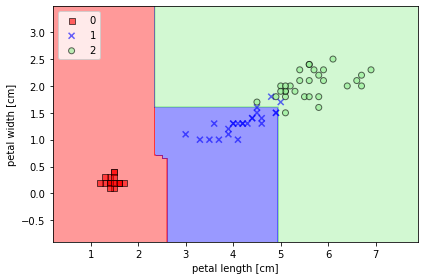

Train accuracy: 0.972603
Test accuracy: 0.977778


In [ ]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

forest = RandomForestClassifier(criterion='entropy',
                                n_estimators=25, # 25
                                max_features='sqrt', #auto, sqrt, log2, None
                                max_depth=1, # 1
                                random_state=1,
                                n_jobs=2)
forest.fit(X_train, y_train)

plot_decision_regions(X_train, y_train, classifier=forest)

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

print('Train accuracy: %f' % accuracy_score(forest.predict(X_train), y_train))
print('Test accuracy: %f' % accuracy_score(forest.predict(X_test), y_test))

---
### RF: Feature Importance

In [ ]:
forest.feature_importances_

array([0.64, 0.36])

<ipython-input-7-8bc0b4625950>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(feature_names)


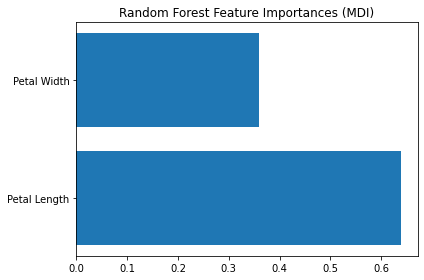

In [ ]:
forest.feature_importances_

y_ticks = np.arange(0, X.shape[1])
fig, ax = plt.subplots()
ax.barh(y_ticks, forest.feature_importances_)
ax.set_yticklabels(feature_names)
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)") # MDI: Mean Decrease in Impurity
fig.tight_layout()
plt.show()

---
## Logistic Regression

#### Data
 - Input: $x^{(i)} \in X$
 - Label: $y^{(i)} \in \{0,1\}$ (Binary classification)
 - $i=1,2,\dots,n$

#### Class probabilities:

$$
p = \mathbb P(Y=1 | X=x) \\
1-p = \mathbb P(Y=0 | X=x)
$$

#### Log odds-ratio (logit)
$$
  \log \frac{p}{1-p}
$$

- If logit > 0, decision is $Y=1$
- Otherwise, $Y=0$


#### Modeling the logit with a linear function:

$$
  \log \frac{p}{1-p} = w^T x = \sum_{i=1}^m w_i x_i
$$

Reordering the terms in p, we get the following expression:

$$
 p = \mathbb P(Y=1 | X=x) = \frac{1}{1 + \exp(-w^Tx)}
$$

We call the function $\sigma(z) = \frac{1}{1+\exp(-z)}$ as the **sigmoid** function

#### Sigmoid Function

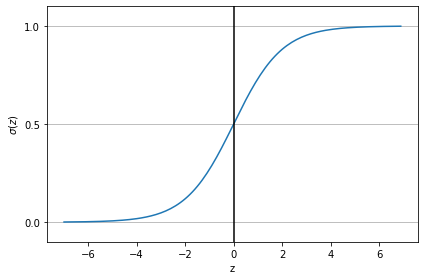

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

z = np.arange(-7, 7, 0.1)
phi_z = sigmoid(z)

plt.plot(z, phi_z)
plt.axvline(0.0, color='k')
plt.ylim(-0.1, 1.1)
plt.xlabel('z')
plt.ylabel('$\sigma (z)$')

# y axis ticks and gridline
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)

plt.tight_layout()
plt.show()

---

### LR can be seen as a simple neural network (perceptron)

<img src="https://raw.githubusercontent.com/sanglee/BDS_WS/master/img/03_03.png" width=700>

---

### Learning by Maximum Likelihood Estimation (MLE)

- We make **i.i.d.** assumption on data points:
  - Data points are **independently** sampled,
  - Each data point is sampled according to our model, $\mathbb P(Y=1|X=x)$ (**identically distributed**)

#### Likelihood function

- The (conditional) probability of observing the training data $(x^{(i)},y^{(i)})$, $i=1,2, \dots, n$

$$
 L(w) = \mathbb P(y^{(1)},y^{(2)},\dots,y^{(n)}|x^{(1)},x^{(2)},\dots,x^{(n)};w) = \prod_{i=1}^n \mathbb P(y^{(i)}|x^{(i)};w) = \prod_{i=1}^n \sigma(z^{(i)})^{y^{(i)}} (1-\sigma(z^{(i)}))^{1-y^{(i)}} 
$$

- Note that the labels are $y^{(i)} \in \{0,1\}$

#### Log Likelihood Function
$$
 \ell(w) = \log L(w) = \sum_{i=1}^n y^{(i)} \log \sigma(w^Tx^{(i)}) + (1-y^{(i)}) \log (1-\sigma(w^Tx^{(i)}))
$$

#### Logistic Regression Training Problem
$$
\max_w \;\; \ell(w)
$$

---
### LR in Scikit-learn

Train accuracy: 0.958904
Test accuracy: 0.977778


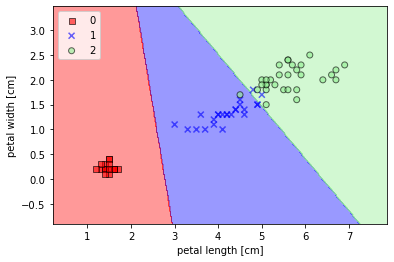

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr = LogisticRegression()
lr.fit(X_train, y_train)

plot_decision_regions(X_train, y_train, classifier=lr)
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')

print('Train accuracy: %f' % accuracy_score(lr.predict(X_train), y_train))
print('Test accuracy: %f' % accuracy_score(lr.predict(X_test), y_test))
#print(lr.predict_proba(X_test)) # probability output

---

### Underfitting vs. Overfitting

<img src="https://raw.githubusercontent.com/sanglee/BDS_WS/master/img/03_06.png" width=700>

#### Regularized Logistic Regression Training Problem
$$
\max_w \;\; \ell(w) + C \|w\|_2^2
$$

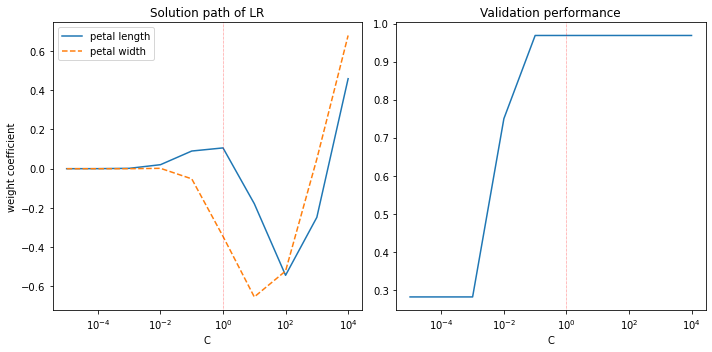

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_val_std = sc.transform(X_val)
X_test_std = sc.transform(X_test)

# C large => simpler
#

weights, params, perf = [], [], []
for c in np.arange(-5., 5.):
    lr = LogisticRegression(C=10.**c) # penalty='l2' by default
#     lr.fit(X_train, y_train)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)
#     y_pred = lr.predict(X_val)
    y_pred = lr.predict(X_val_std)
    perf.append(accuracy_score(y_pred, y_val))

perf_max = np.max(perf)
    
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
weights = np.array(weights)
plt.plot(params, weights[:, 0],
         label='petal length')
plt.plot(params, weights[:, 1], linestyle='--',
         label='petal width')
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.legend(loc='upper left')
plt.xscale('log')
plt.title('Solution path of LR')
plt.axvline(perf_max, 0, 2, color="red", linestyle=':', linewidth=.5)

plt.subplot(1,2,2)
plt.plot(params, perf)
plt.xlabel('C')
plt.xscale('log')
plt.title('Validation performance')
plt.axvline(perf_max, 0, 1, color="red", linestyle=':', linewidth=.5)
plt.tight_layout()

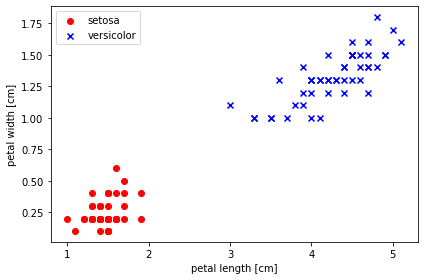

In [ ]:
# plot data
plt.scatter(X[:50, 0], X[:50, 1],
            color='red', marker='o', label='setosa')
plt.scatter(X[50:100, 0], X[50:100, 1],
            color='blue', marker='x', label='versicolor')

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

---
## Summary

__Supervised Learning: Classification__


__Random Forest__
- Ensemble learning: use a collection of weak classifiers with majority voting
  - Random Forest: a collection of simple decision trees (decision stump)
- Hyperparameters
  - criterion='entropy'
  - n_estimators
  - max_features
  - max_depth
- Pros
  - Robust to input noise
  - Sampling on both samples & features: data can be used as much as possible, even in the existence of missing values
  - Feature scaling is not needed
- Cons
  - Time to compute many weak classifiers

__Logistic Regression__
- Model the probability of classes
- Learns a linear (simple) decision boundary
  - LR is indeed the same as the perceptron (the simplest neural network without hidden layers)
- Overfitting is controlled by regularization
- Learning is done by well-established statistical method, MLE
  - The technique is also used for learning deep neural networks